In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, Activation, concatenate
from tensorflow import feature_column

import datetime
import os
import gc

import joblib


In [68]:
df_train = pd.read_csv('data/train.csv')

In [69]:
df_train.rename(columns={'age_approx':'age', 'anatom_site_general_challenge':'anatom'}, inplace = True)
df_train.dropna(axis=0, inplace = True)
df_train.isnull().sum()

image_name          0
patient_id          0
sex                 0
age                 0
anatom              0
diagnosis           0
benign_malignant    0
target              0
dtype: int64

In [70]:
df_train.head()

,image_name,patient_id,sex,age,anatom,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [71]:
Tabular_data = df_train.drop(['benign_malignant', 'patient_id', 'diagnosis'], axis = 1)
targets = df_train.target
Tabular_data.head()

,image_name,sex,age,anatom,target
0,ISIC_2637011,male,45.0,head/neck,0
1,ISIC_0015719,female,45.0,upper extremity,0
2,ISIC_0052212,female,50.0,lower extremity,0
3,ISIC_0068279,female,45.0,head/neck,0
4,ISIC_0074268,female,55.0,upper extremity,0


In [72]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in Tabular_data.image_name]

In [73]:
Tabular_data = Tabular_data.drop(['image_name'], axis = 1)

In [74]:
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [75]:
def create_df(image, tabular, target):
    image = process_image(image)

    return {'img_inp': image, 'tab_inp':  tabular}, target

In [76]:
X = filenames
#y = targets

In [77]:
# Set number of images to use for experimenting
First_Image = 0
Last_Image = 3000

In [78]:
x_train, x_val, tabular_train, tabular_val = train_test_split(X[:], Tabular_data[:], test_size = 0.2, random_state = 42)

In [79]:
y_train = pd.get_dummies(tabular_train.target)
tabular_train.drop('target', axis = 1, inplace = True)

y_val = pd.get_dummies(tabular_val.target)
tabular_val.drop('target', axis = 1, inplace = True)

In [80]:
BATCH_SIZE = 45
    
    
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train),dict(tabular_train),tf.constant(y_train)))
train_data = train_data.map(create_df).shuffle(buffer_size = len(x_train))
train_data = train_data.batch(BATCH_SIZE)
    
    
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val),dict(tabular_val),tf.constant(y_val)))
val_data = val_data.map(create_df).batch(BATCH_SIZE)

In [81]:
feature_columns = []
feature_input = {}


age = feature_column.numeric_column('age')
feature_columns.append(age)
feature_input['age'] = tf.keras.Input(shape = (1,), name = 'age')

age_buckets = feature_column.bucketized_column(age, boundaries=[30, 45, 85])
feature_columns.append(age_buckets)
#feature_input['age_buckets'] = tf.keras.Input(shape = (3,), name = 'age_buckets')

sex = feature_column.categorical_column_with_vocabulary_list('sex', ['male', 'female'])
sex = feature_column.indicator_column(sex)
feature_columns.append(sex)
feature_input['sex'] = tf.keras.Input(shape = (1,), name = 'sex', dtype = tf.string)

anatom = feature_column.categorical_column_with_hash_bucket('anatom', hash_bucket_size=6)
anatom = feature_column.indicator_column(anatom)
feature_columns.append(anatom)
feature_input['anatom'] = tf.keras.Input(shape = (1,), name = 'anatom', dtype=tf.string)


feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
#feature_layer_outputs = feature_layer(feature_input)

In [82]:
feature_input

{'age': <tf.Tensor 'age_2:0' shape=(None, 1) dtype=float32>,
 'sex': <tf.Tensor 'sex_2:0' shape=(None, 1) dtype=string>,
 'anatom': <tf.Tensor 'anatom_2:0' shape=(None, 1) dtype=string>}

In [83]:
val_data

<BatchDataset shapes: ({img_inp: (None, 256, 256, 3), tab_inp: {sex: (None,), age: (None,), anatom: (None,)}}, (None, 2)), types: ({img_inp: tf.float32, tab_inp: {sex: tf.string, age: tf.float64, anatom: tf.string}}, tf.uint8)>

In [84]:
INPUT_SIZE = [IMG_SIZE,IMG_SIZE, 3]
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 128
HIDDEN_SIZE3 = 64
OUTPUT_SIZE = 2

In [85]:
Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

In [86]:
Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

In [87]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [88]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
        model.summary()
    else:        
        img_inp = Input(shape = INPUT_SIZE, name = 'img_inp')
        #tab_inp = Input(shape = (), name = 'tab_inp', dtype = 'float32') 

        x1 = Conv2D(64, kernel_size=5, padding='VALID', activation='relu')(img_inp)
 
        x1 = MaxPooling2D(pool_size=5)(x1)  

        x1 = Conv2D(128, kernel_size = 5, padding = 'VALID', activation = 'relu')(x1)
        x1 = MaxPooling2D(pool_size=5)(x1)

        x1 = Conv2D(256, kernel_size = 5, padding = 'VALID', activation = 'relu')(x1)
        x1 = MaxPooling2D(pool_size=5)(x1)

        x1 = Flatten()(x1)

        x2 = feature_layer(feature_input)
        x2 = Dense(50)(x2)
        #x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)   

        concat = concatenate([x1, x2])
        #concat = x1
        #concat = Dense(256, activation = 'relu')(concat)
        #concat = BatchNormalization()(concat)
        #concat = Dropout(0.2)(concat)

        
        concat = Dense(128, activation = 'relu')(concat)
        #concat = BatchNormalization()(concat)
        #concat = Dropout(0.2)(concat)

        
        #concat = Dense(64, activation = 'relu')(concat)
        #concat = BatchNormalization()(concat)
        #concat = Dropout(0.2)(concat)


        outputs = Dense(OUTPUT_SIZE, activation= 'softmax')(concat)

        model = tf.keras.models.Model(inputs = [img_inp, feature_input], outputs = outputs)
        #model = tf.keras.models.Model(inputs = img_inp, outputs = outputs)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-3),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

        model.summary()
    return model

In [89]:
model = create_model(False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_inp (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 252, 252, 64) 4864        img_inp[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 50, 50, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 46, 46, 128)  204928      max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [90]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [91]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [92]:
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [93]:
tensorboard = create_tensorboard_callback()

In [94]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0)

In [95]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

3305

In [96]:
train_data

<BatchDataset shapes: ({img_inp: (None, 256, 256, 3), tab_inp: {sex: (None,), age: (None,), anatom: (None,)}}, (None, 2)), types: ({img_inp: tf.float32, tab_inp: {sex: tf.string, age: tf.float64, anatom: tf.string}}, tf.uint8)>

In [97]:
history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[EarlyStopping, Rate,tensorboard], class_weight = class_weights)

Epoch 1/100
579/579 [==============================] - 2862s 5s/step - loss: 0.7399 - binary_accuracy: 0.4681 - auc_2: 0.4529 - val_loss: 0.4136 - val_binary_accuracy: 0.9842 - val_auc_2: 0.9910 - lr: 0.0010
Epoch 2/100
579/579 [==============================] - 2448s 4s/step - loss: 0.6661 - binary_accuracy: 0.6035 - auc_2: 0.6295 - val_loss: 0.5770 - val_binary_accuracy: 0.7123 - val_auc_2: 0.7824 - lr: 0.0010
Epoch 3/100
579/579 [==============================] - 2660s 5s/step - loss: 0.6109 - binary_accuracy: 0.6805 - auc_2: 0.7454 - val_loss: 0.6524 - val_binary_accuracy: 0.6195 - val_auc_2: 0.6748 - lr: 1.0000e-04
Epoch 4/100
579/579 [==============================] - 2795s 5s/step - loss: 0.6068 - binary_accuracy: 0.6509 - auc_2: 0.7095 - val_loss: 0.5828 - val_binary_accuracy: 0.7066 - val_auc_2: 0.7732 - lr: 1.0000e-05
Epoch 5/100
579/579 [==============================] - 2855s 5s/step - loss: 0.6066 - binary_accuracy: 0.7055 - auc_2: 0.7724 - val_loss: 0.5863 - val_binary_ac

In [98]:
#%tensorboard --logdir logs

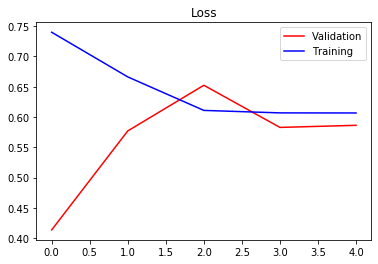

In [99]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [100]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [101]:
sfx = "CNN_Img_Tab"
save_model(model, suffix=sfx)

Saving model to: models\20200716152917-CNN_Img_Tab.h5...


'models\\20200716152917-CNN_Img_Tab.h5'